# Hotel Cancellation Machine Learning Model

In [1]:
#installieren der relevanten libraries
#%pip install -r requirements.txt

In [2]:
#importieren der relevanten libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix

%matplotlib inline

## 1. Load and inspect dataset

The Kaggle dataset on hotel reservations provides detailed information about bookings made by customers. It offers valuable insights for analyzing booking patterns, demand forecasting, and customer behavior in the hospitality industry. With a rich collection of data, it serves as a valuable resource for researchers and data scientists working on hotel management and related fields.

In [3]:
#laden des main dataframes und Darstellung der ersten 5 Zeilen
csv_url = "https://raw.githubusercontent.com/Flitschi7/stornierungsvorhersage-im-hotelgewerbe/main/hotel_reservations.csv"
main_df = pd.read_csv(csv_url)
main_df.head()


Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights   
0   INN00001             2               0                     1  \
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space   
0                  2       Meal Plan 1                           0  \
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date   
0        Room_Type 1        224          2017             10             2  \
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations   
0             Offline               0                             0  \
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room   
0                                     0               65.00  \
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

In [4]:
#Dataframe mit den Spaltennamen und den Datentypen der Spalten erstellen
main_df.describe(include='all')

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights   
count       36275  36275.000000    36275.000000          36275.000000  \
unique      36275           NaN             NaN                   NaN   
top      INN00001           NaN             NaN                   NaN   
freq            1           NaN             NaN                   NaN   
mean          NaN      1.844962        0.105279              0.810724   
std           NaN      0.518715        0.402648              0.870644   
min           NaN      0.000000        0.000000              0.000000   
25%           NaN      2.000000        0.000000              0.000000   
50%           NaN      2.000000        0.000000              1.000000   
75%           NaN      2.000000        0.000000              2.000000   
max           NaN      4.000000       10.000000              7.000000   

        no_of_week_nights type_of_meal_plan  required_car_parking_space   
count        36275.000000             36275                36275.000000  \
unique                NaN                 4                         NaN   
top                   NaN       Meal Plan 1                         NaN   
freq                  NaN             27835                         NaN   
mean             2.204300               NaN                    0.030986   
std              1.410905               NaN                    0.173281   
min              0.000000               NaN                    0.000000   
25%              1.000000               NaN                    0.000000   
50%              2.000000               NaN                    0.000000   
75%              3.000000               NaN                    0.000000   
max             17.000000               NaN                    1.000000   

       room_type_reserved     lead_time  arrival_year  arrival_month   
count               36275  36275.000000  36275.000000   36275.000000  \
unique                  7           NaN           NaN            NaN   
top           Room_Type 1           NaN           NaN            NaN   
freq                28130           NaN           NaN            NaN   
mean                  NaN     85.232557   2017.820427       7.423653   
std                   NaN     85.930817      0.383836       3.069894   
min                   NaN      0.000000   2017.000000       1.000000   
25%                   NaN     17.000000   2018.000000       5.000000   
50%                   NaN     57.000000   2018.000000       8.000000   
75%                   NaN    126.000000   2018.000000      10.000000   
max                   NaN    443.000000   2018.000000      12.000000   

        arrival_date market_segment_type  repeated_guest   
count   36275.000000               36275    36275.000000  \
unique           NaN                   5             NaN   
top              NaN              Online             NaN   
freq             NaN               23214             NaN   
mean       15.596995                 NaN        0.025637   
std         8.740447                 NaN        0.158053   
min         1.000000                 NaN        0.000000   
25%         8.000000                 NaN        0.000000   
50%        16.000000                 NaN        0.000000   
75%        23.000000                 NaN        0.000000   
max        31.000000                 NaN        1.000000   

        no_of_previous_cancellations  no_of_previous_bookings_not_canceled   
count                   36275.000000                          36275.000000  \
unique                           NaN                                   NaN   
top                              NaN                                   NaN   
freq                             NaN                                   NaN   
mean                        0.023349                              0.153411   
std                         0.368331                              1.754171   
min                         0.000000                              0.000000   
25%                

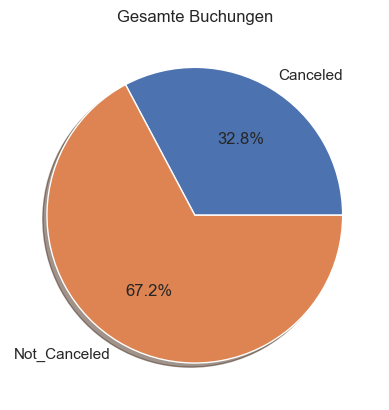

In [5]:
#überprüfen wie die Verteilung der stornierten Buchungen ist
booking_status_count = main_df.groupby('booking_status')['Booking_ID'].count().reset_index()
def func(pct):
  return "{:1.1f}%".format(pct)
plt.pie(booking_status_count.Booking_ID.values, labels=booking_status_count.booking_status.values, autopct=lambda pct: func(pct), shadow=True)
plt.title('Gesamte Buchungen')
plt.show()


Da die Verteilung nicht 1/10 sondern ca 3/10 ist. Wird erstmal keine Art der Datengleichstellung betrachtet.

# 2. Data cleaning

In [6]:
#Duplikate in den Daten finden
main_df[main_df.duplicated(keep=False)] 

Empty DataFrame
Columns: [Booking_ID, no_of_adults, no_of_children, no_of_weekend_nights, no_of_week_nights, type_of_meal_plan, required_car_parking_space, room_type_reserved, lead_time, arrival_year, arrival_month, arrival_date, market_segment_type, repeated_guest, no_of_previous_cancellations, no_of_previous_bookings_not_canceled, avg_price_per_room, no_of_special_requests, booking_status]
Index: []

In [7]:
#Duplikate in den IDs finden
main_df['Booking_ID'][main_df['Booking_ID'].duplicated(keep=False)] 

Series([], Name: Booking_ID, dtype: object)

In [8]:
#Nullwerte in den Daten finden
main_df.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [9]:
#ID Spalte löschen
main_df = main_df.drop(['Booking_ID'], axis = 1)


In [10]:
#arrival year und date sind keine relevanten features
main_df = main_df.drop(['arrival_year','arrival_date'], axis = 1)
#arrival month kann noch als feature genutzt werden da eventuell saisonale Schwankungen auftreten

In [11]:
main_df.describe(include='all')

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights   
count   36275.000000    36275.000000          36275.000000       36275.000000  \
unique           NaN             NaN                   NaN                NaN   
top              NaN             NaN                   NaN                NaN   
freq             NaN             NaN                   NaN                NaN   
mean        1.844962        0.105279              0.810724           2.204300   
std         0.518715        0.402648              0.870644           1.410905   
min         0.000000        0.000000              0.000000           0.000000   
25%         2.000000        0.000000              0.000000           1.000000   
50%         2.000000        0.000000              1.000000           2.000000   
75%         2.000000        0.000000              2.000000           3.000000   
max         4.000000       10.000000              7.000000          17.000000   

       type_of_meal_plan  required_car_parking_space room_type_reserved   
count              36275                36275.000000              36275  \
unique                 4                         NaN                  7   
top          Meal Plan 1                         NaN        Room_Type 1   
freq               27835                         NaN              28130   
mean                 NaN                    0.030986                NaN   
std                  NaN                    0.173281                NaN   
min                  NaN                    0.000000                NaN   
25%                  NaN                    0.000000                NaN   
50%                  NaN                    0.000000                NaN   
75%                  NaN                    0.000000                NaN   
max                  NaN                    1.000000                NaN   

           lead_time  arrival_month market_segment_type  repeated_guest   
count   36275.000000   36275.000000               36275    36275.000000  \
unique           NaN            NaN                   5             NaN   
top              NaN            NaN              Online             NaN   
freq             NaN            NaN               23214             NaN   
mean       85.232557       7.423653                 NaN        0.025637   
std        85.930817       3.069894                 NaN        0.158053   
min         0.000000       1.000000                 NaN        0.000000   
25%        17.000000       5.000000                 NaN        0.000000   
50%        57.000000       8.000000                 NaN        0.000000   
75%       126.000000      10.000000                 NaN        0.000000   
max       443.000000      12.000000                 NaN        1.000000   

        no_of_previous_cancellations  no_of_previous_bookings_not_canceled   
count                   36275.000000                          36275.000000  \
unique                           NaN                                   NaN   
top                              NaN                                   NaN   
freq                             NaN                                   NaN   
mean                        0.023349                              0.153411   
std                         0.368331                              1.754171   
min                         0.000000                              0.000000   
25%                         0.000000                              0.000000   
50%                         0.000000                              0.000000   
75%                         0.000000                              0.000000   
max                        13.000000                             58.000000   

        avg_price_per_room  no_of_special_requests booking_status  
count         36275.000000            36275.000000          36275  
unique                 NaN                     NaN              2  
top                    NaN                     NaN   Not_Canceled  
freq                   N

In [12]:
#ändern des Datentyps der Spalte booking_status
main_df['booking_status'] = main_df['booking_status'].map({'Canceled': 0, 'Not_Canceled': 1})


In [13]:
main_df.describe(include='all')

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights   
count   36275.000000    36275.000000          36275.000000       36275.000000  \
unique           NaN             NaN                   NaN                NaN   
top              NaN             NaN                   NaN                NaN   
freq             NaN             NaN                   NaN                NaN   
mean        1.844962        0.105279              0.810724           2.204300   
std         0.518715        0.402648              0.870644           1.410905   
min         0.000000        0.000000              0.000000           0.000000   
25%         2.000000        0.000000              0.000000           1.000000   
50%         2.000000        0.000000              1.000000           2.000000   
75%         2.000000        0.000000              2.000000           3.000000   
max         4.000000       10.000000              7.000000          17.000000   

       type_of_meal_plan  required_car_parking_space room_type_reserved   
count              36275                36275.000000              36275  \
unique                 4                         NaN                  7   
top          Meal Plan 1                         NaN        Room_Type 1   
freq               27835                         NaN              28130   
mean                 NaN                    0.030986                NaN   
std                  NaN                    0.173281                NaN   
min                  NaN                    0.000000                NaN   
25%                  NaN                    0.000000                NaN   
50%                  NaN                    0.000000                NaN   
75%                  NaN                    0.000000                NaN   
max                  NaN                    1.000000                NaN   

           lead_time  arrival_month market_segment_type  repeated_guest   
count   36275.000000   36275.000000               36275    36275.000000  \
unique           NaN            NaN                   5             NaN   
top              NaN            NaN              Online             NaN   
freq             NaN            NaN               23214             NaN   
mean       85.232557       7.423653                 NaN        0.025637   
std        85.930817       3.069894                 NaN        0.158053   
min         0.000000       1.000000                 NaN        0.000000   
25%        17.000000       5.000000                 NaN        0.000000   
50%        57.000000       8.000000                 NaN        0.000000   
75%       126.000000      10.000000                 NaN        0.000000   
max       443.000000      12.000000                 NaN        1.000000   

        no_of_previous_cancellations  no_of_previous_bookings_not_canceled   
count                   36275.000000                          36275.000000  \
unique                           NaN                                   NaN   
top                              NaN                                   NaN   
freq                             NaN                                   NaN   
mean                        0.023349                              0.153411   
std                         0.368331                              1.754171   
min                         0.000000                              0.000000   
25%                         0.000000                              0.000000   
50%                         0.000000                              0.000000   
75%                         0.000000                              0.000000   
max                        13.000000                             58.000000   

        avg_price_per_room  no_of_special_requests  booking_status  
count         36275.000000            36275.000000    36275.000000  
unique                 NaN                     NaN             NaN  
top                    NaN                     NaN             NaN  
freq                

In [14]:
clean_df =main_df.copy()

# 3. Data Understanding

## 3.1 checking numeric Data

In [15]:
numeric_features = clean_df.select_dtypes(include=[np.number])
numeric_features.dtypes


no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
required_car_parking_space                int64
lead_time                                 int64
arrival_month                             int64
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                            int64
dtype: object

required_car_parking_space und repeated_guest sind kategoriale daten, da es nur ja (1) oder nein (0) gibt.

### 3.1.1 Vizualisation of the data

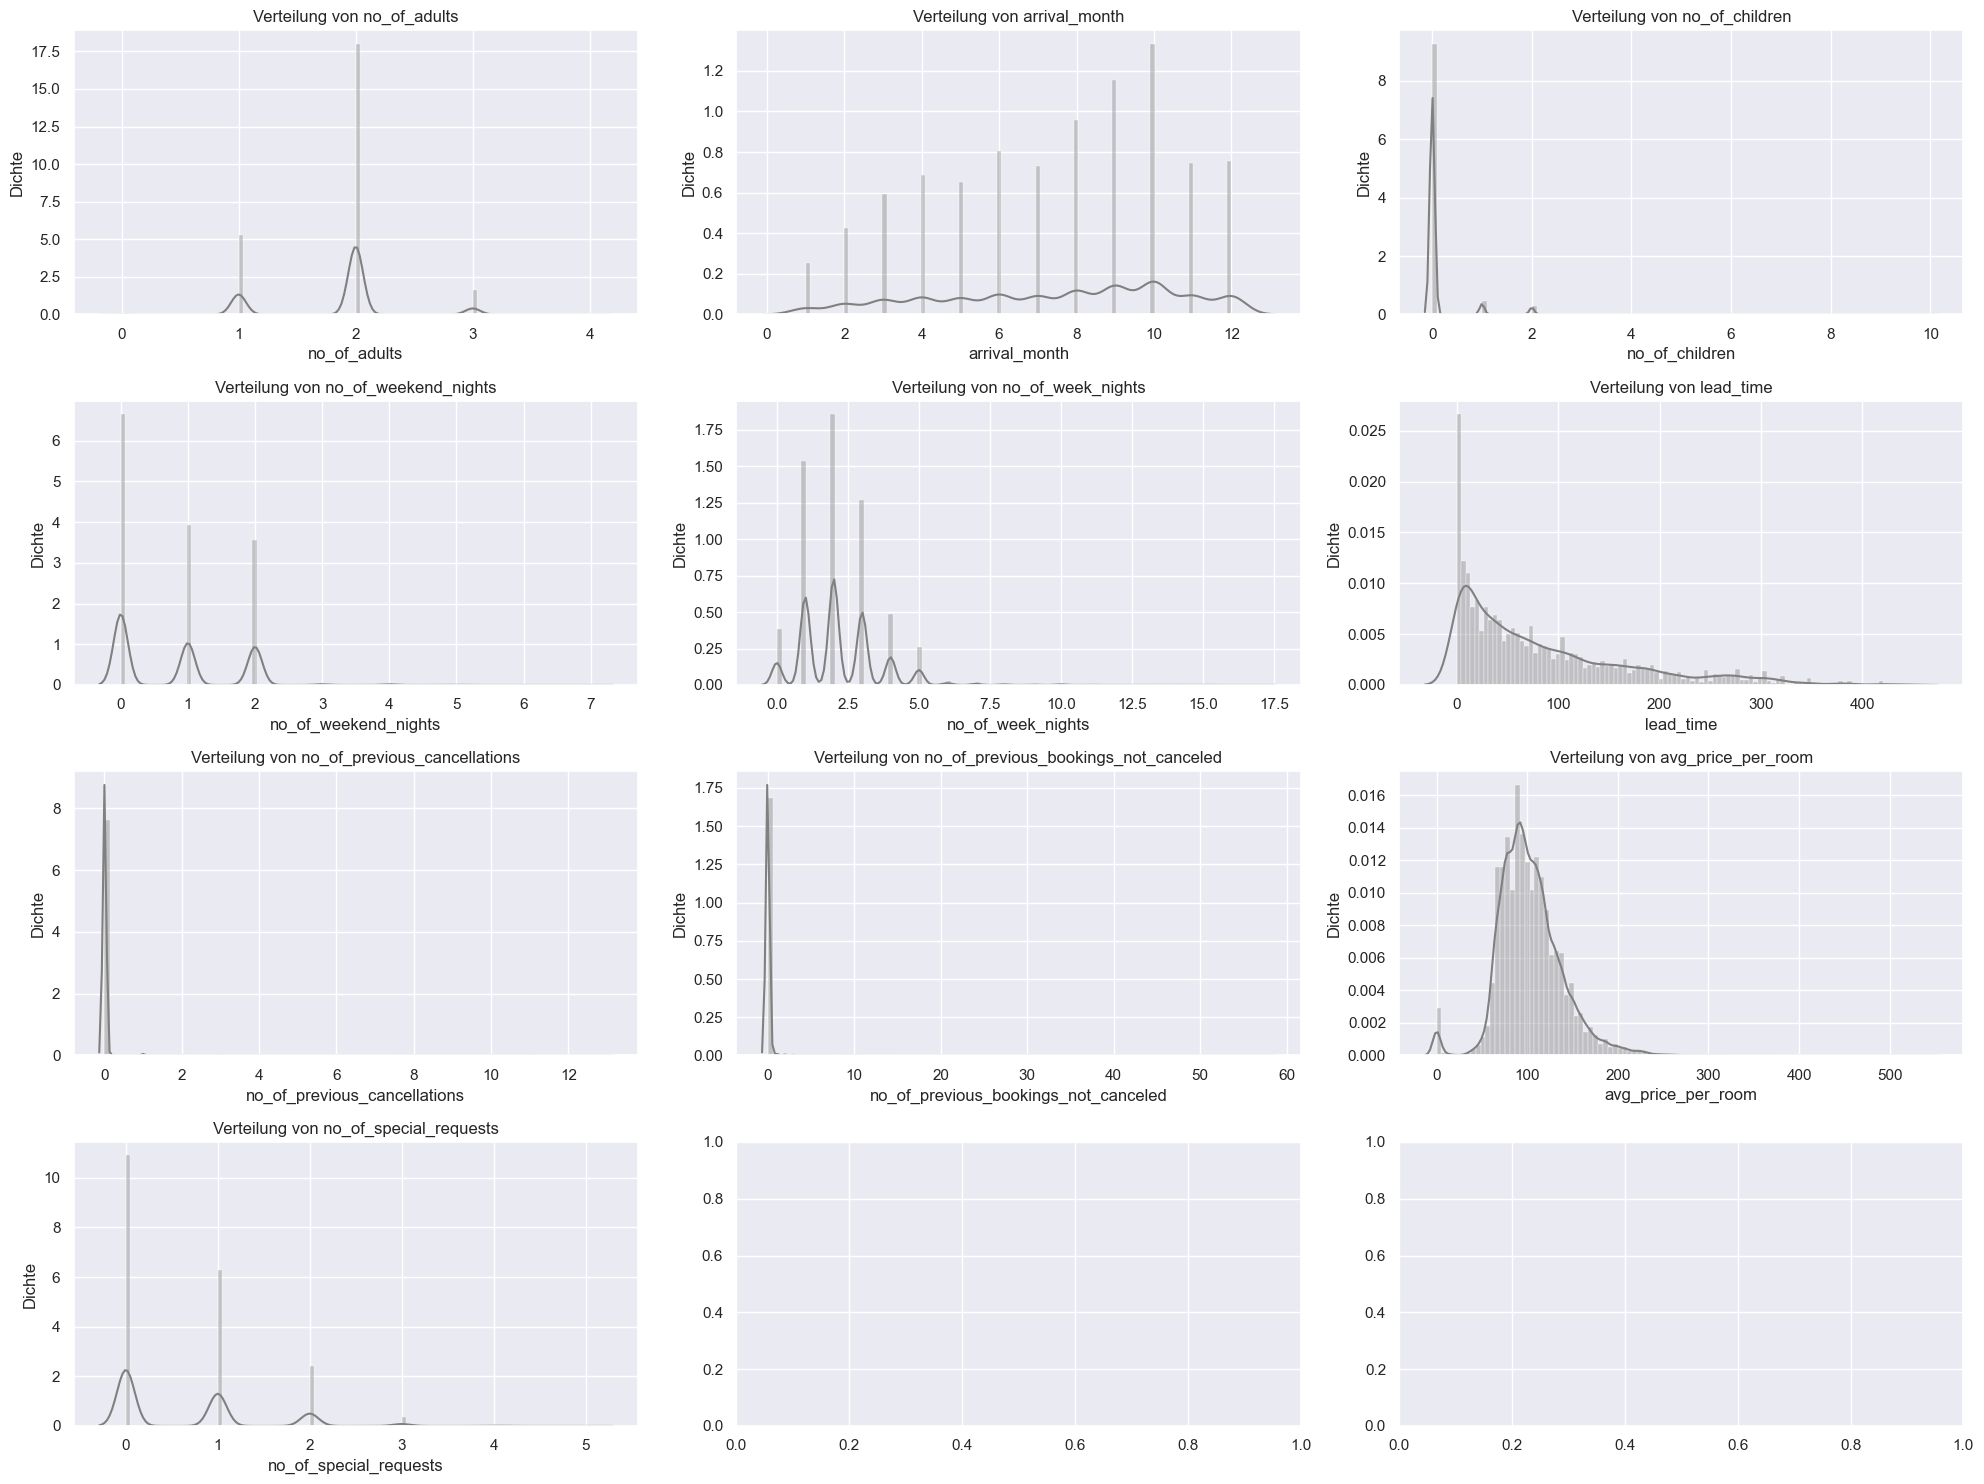

In [16]:
features = ['no_of_adults', 'arrival_month', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled','avg_price_per_room','no_of_special_requests']

fig, axs = plt.subplots(4, 3, figsize=(20, 15))
axs = np.ravel(axs)

for i, feature in enumerate(features):
    sns.histplot(numeric_features[feature], kde=True, stat='density', kde_kws=dict(cut=3), bins=100, color='gray', alpha=0.4, linewidth=0.25, ax=axs[i])
    axs[i].set_title(f'Verteilung von {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Dichte')

plt.tight_layout()
plt.show()


In [17]:
for feature in features:
    distribution = numeric_features[feature].value_counts().reset_index()
    distribution.columns = [feature, 'frequency']
    distribution = distribution.sort_values(feature)
    
    print(f"Verteilung von '{feature}':")
    print(distribution)
    print()

Verteilung von 'no_of_adults':
   no_of_adults  frequency
3             0        139
1             1       7695
0             2      26108
2             3       2317
4             4         16

Verteilung von 'arrival_month':
    arrival_month  frequency
11              1       1014
10              2       1704
9               3       2358
7               4       2736
8               5       2598
3               6       3203
6               7       2920
2               8       3813
1               9       4611
0              10       5317
5              11       2980
4              12       3021

Verteilung von 'no_of_children':
   no_of_children  frequency
0               0      33577
1               1       1618
2               2       1058
3               3         19
4               9          2
5              10          1

Verteilung von 'no_of_weekend_nights':
   no_of_weekend_nights  frequency
0                     0      16872
1                     1       9995
2              

## 3.1.2 Interpretation of the data
#### Verteilung von 'no_of_adults':

Die Mehrheit der Buchungen hat 2 Erwachsene.
Es gibt jedoch auch einige Buchungen mit 1, 3 und 4 Erwachsenen.
Es gibt 139 Buchungen, bei denen keine Erwachsenen angegeben sind, was möglicherweise auf Fehler oder ungewöhnliche Situationen hinweist.

#### Verteilung von arrival_month

Die Mehrheit der Besuche erfolgt im Oktober, das lässt eventuell darauf schließen dass hier eine Saisonalität vorliegt

#### Verteilung von 'no_of_children':

Die Mehrheit der Buchungen hat keine Kinder.
Es gibt jedoch auch Buchungen mit 1, 2, 3, 4, 5 und sogar 10 Kindern.
Ein Problem könnte sein, dass es einige Buchungen gibt, die eine ungewöhnlich hohe Anzahl von Kindern angeben, wie z.B. 9 oder 10 Kinder. Dies könnte auf Fehler oder falsche Angaben hinweisen.

#### Verteilung von 'no_of_weekend_nights':

Die Mehrheit der Buchungen hat entweder keine Wochenendnächte oder 1 oder 2 Wochenendnächte.
Es gibt einige Buchungen mit 3, 4, 5, 6 und sogar 7 Wochenendnächten.

#### Verteilung von 'no_of_week_nights':

Die Mehrheit der Buchungen hat entweder 1 oder 2 Wochennächte.
Es gibt jedoch auch Buchungen mit bis zu 17 Wochennächten.


#### Verteilung von 'lead_time':

Die Verteilung der Vorlaufzeit (Zeit zwischen Buchung und Ankunft) ist ziemlich breit gestreut.
Es gibt Buchungen mit sehr kurzer Vorlaufzeit (0 bis 5 Tage) sowie Buchungen mit sehr langer Vorlaufzeit (mehrere Monate).
Hier ist der skew nach rechts sehr hoch


#### Verteilung von 'no_of_previous_cancellations':

Die Mehrheit der Buchungen hatte keine vorherigen Stornierungen.
Es gibt jedoch auch Buchungen mit 1, 2, 3, 4, 5 und sogar mehreren vorherigen Stornierungen.

#### Verteilung von 'avg_price_per_room':

Die Mehrheit der Buchungen ist um 100 verteilt.
Hier können wir eine Normalverteilung beobachten.
Zudem gibt es Buchungen für den Preis 0, das kann bedeuten, dass falsche Daten vorhanden sind oder per Aktionscode oder Gutschein gebucht wurden.

#### Verteilung von 'no_of_special_requests':

Ab einer Anzahl von 2 speziellen Anforderungen gibt es keine Stornierungen


## 3.1.3 Visualisation of feature to Target Variable

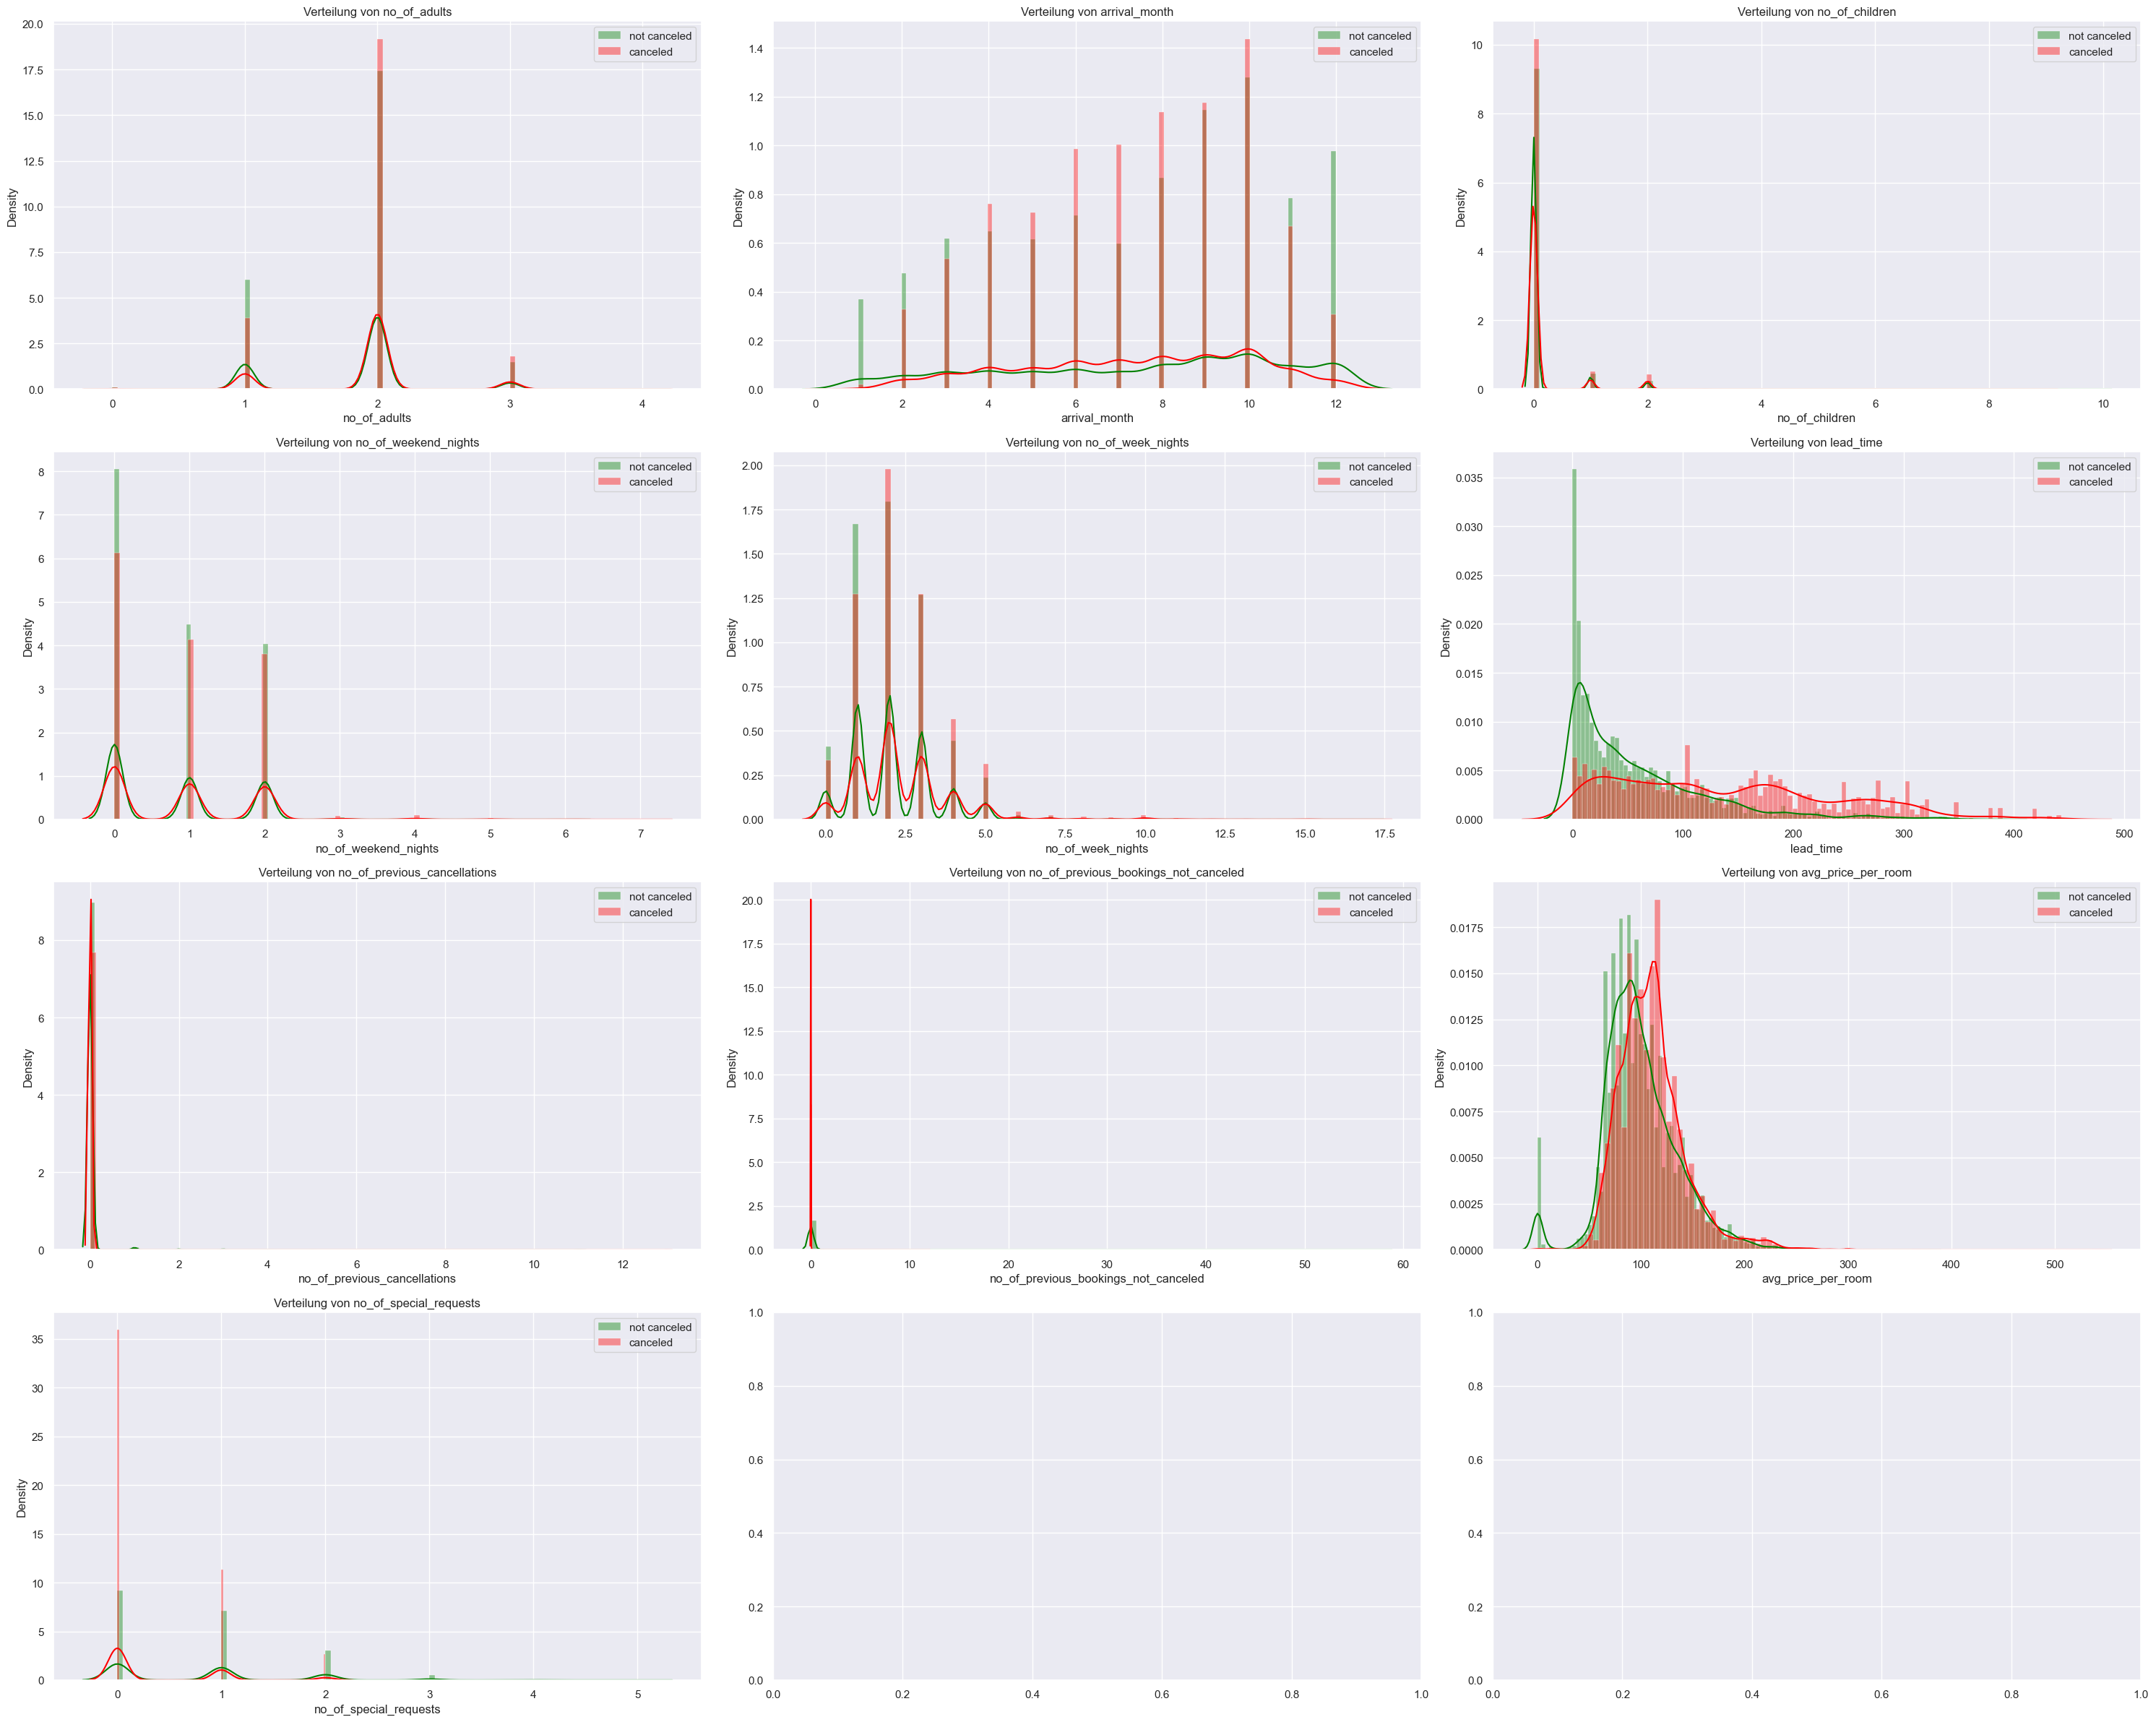

In [18]:
fig, axs = plt.subplots(4, 3, figsize=(30, 24))

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.histplot(numeric_features[clean_df.booking_status == 1][feature],
                 bins=100,
                 color='green',
                 label='not canceled',
                 kde=True,
                 stat='density',
                 kde_kws=dict(cut=3),
                 alpha=0.4,
                 linewidth=0.25,
                 ax=axs[row, col])
    sns.histplot(numeric_features[clean_df.booking_status == 0][feature],
                 bins=100,
                 color='red',
                 label='canceled',
                 kde=True,
                 stat='density',
                 kde_kws=dict(cut=3),
                 alpha=0.4,
                 linewidth=0.25,
                 ax=axs[row, col])
    axs[row, col].set_title(f'Verteilung von {feature}')
    axs[row, col].legend()

plt.tight_layout()
plt.show()



## 3.1.4 Interpretation of the features to target variable

- Vorlaufzeit (lead time): Je länger die Vorlaufzeit, desto wahrscheinlicher ist die Stornierung der Buchung.
- Durchschnittspreis pro Zimmer (avg_price_per_room): Es gibt eine leichte Tendenz, dass höher preisige Zimmer storniert werden
- Es ist zu erkennen dass Buchungen welche in der Winter Urlaubssaison stattfinden tendenziell seltener storniert werden

Diese Fakten basieren auf den beobachteten Daten und zeigen Zusammenhänge zwischen den Merkmalen und dem Buchungsstatus auf.

## 3.1.5 Correlation Matrix

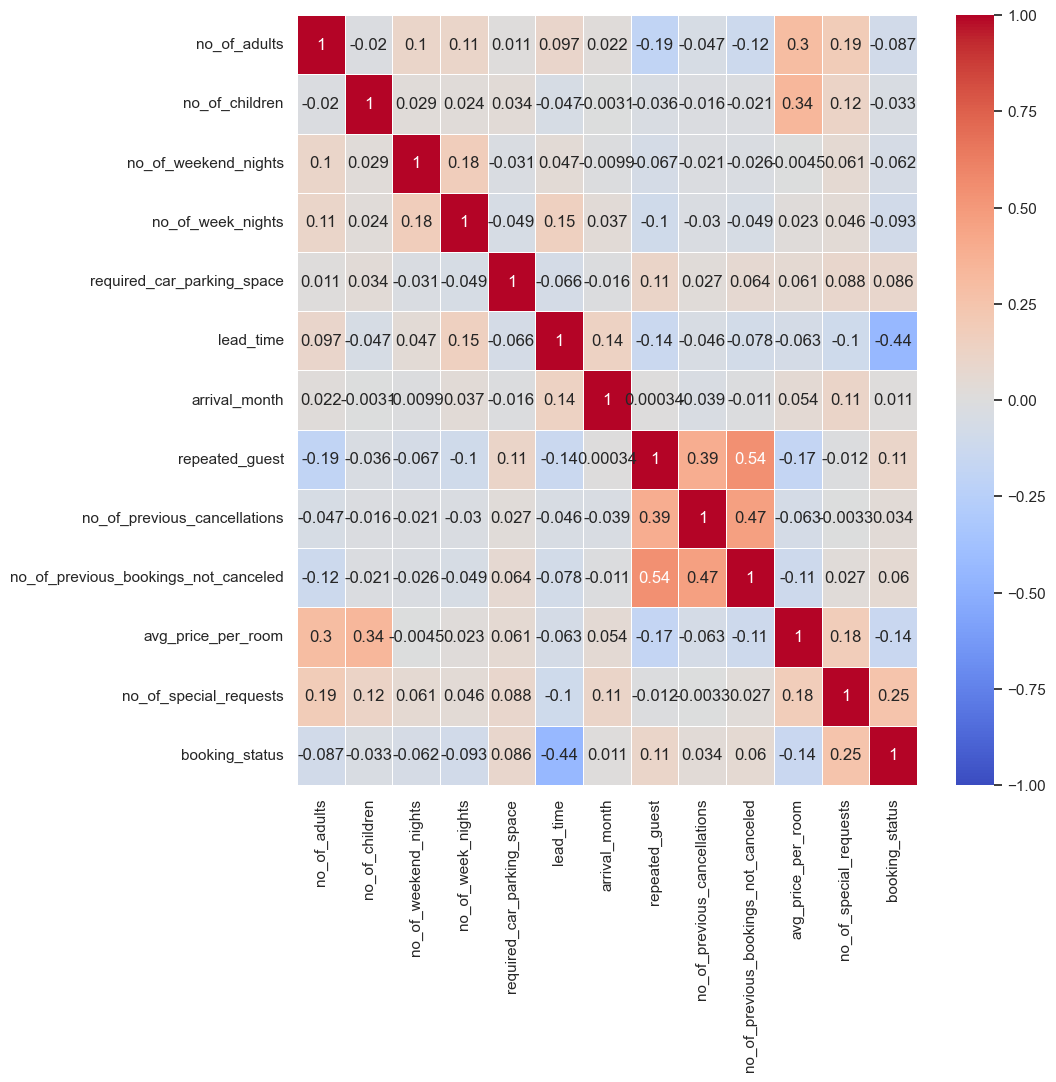

In [19]:
corr = numeric_features.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.show()

Es liegt nur eine negative Korrelation zu der lead_time vor 

Die Nummer der speziellen Anforderungen hat eine leichte Korrelation zum booking status

Zusätzlich korrelieren die Anzahl der gäste mit dem Preis pro Raum.
Und die repeated guest spalte mit no of previous bookings.

## 3.2 Checking categorial Data

Es wäre auch möglich den Monat oder die Anzahl der Gäste mit als Kategoriale Variablen aufzunehmen oder ähnliches.
Da dieses feste Zahlen sind. Jedoch haben diese Variablen auch eine natürliche Rangfolge weshalb diese auch unter numerischen Variablen aufgeführt werden können.

<Figure size 1000x600 with 0 Axes>

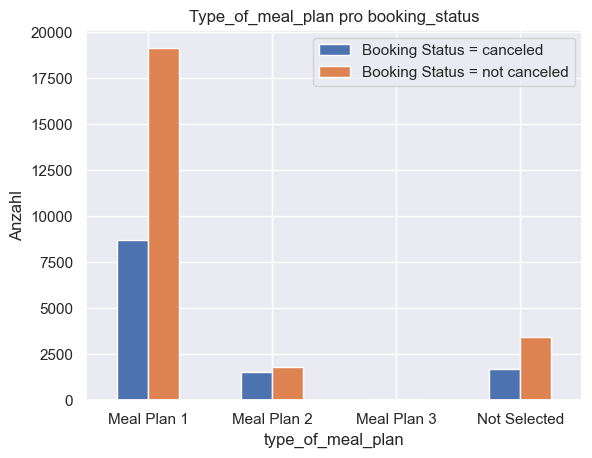

In [20]:
meal_plan_comparison = pd.crosstab(clean_df['type_of_meal_plan'], clean_df['booking_status'])
plt.figure(figsize=(10, 6))
meal_plan_comparison.plot.bar(rot=0)
plt.xlabel('type_of_meal_plan')
plt.ylabel('Anzahl')
plt.legend(['Booking Status = canceled', 'Booking Status = not canceled'])
plt.title('Type_of_meal_plan pro booking_status')
plt.show()

Die Stornierungen sind bei Meal Plan 2 deutlich höher als sonst

<Figure size 1000x600 with 0 Axes>

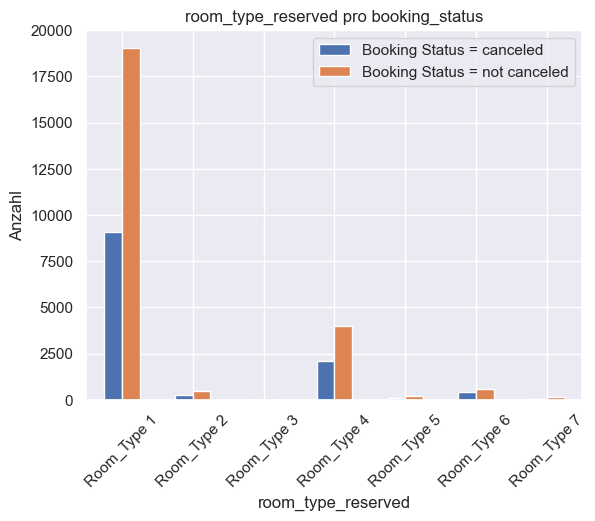

In [21]:
meal_plan_comparison = pd.crosstab(clean_df['room_type_reserved'], clean_df['booking_status'])
plt.figure(figsize=(10, 6))
meal_plan_comparison.plot.bar(rot=0)
plt.xlabel('room_type_reserved')
plt.ylabel('Anzahl')
plt.legend(['Booking Status = canceled', 'Booking Status = not canceled'])
plt.title('room_type_reserved pro booking_status')
plt.xticks(rotation=45)
plt.show()

man erkennt dass es kaum einen Unterschied macht welche Art von Zimmer gewählt

<Figure size 1000x600 with 0 Axes>

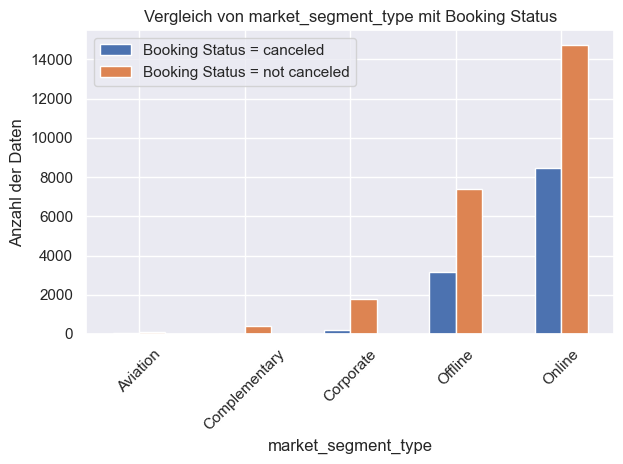

In [22]:
market_segment_comparison = pd.crosstab(clean_df['market_segment_type'], clean_df['booking_status'])
plt.figure(figsize=(10, 6))
market_segment_comparison.plot.bar(rot=0)
plt.xlabel('market_segment_type')
plt.ylabel('Anzahl der Daten')
plt.legend(['Booking Status = canceled', 'Booking Status = not canceled'])
plt.title('Vergleich von market_segment_type mit Booking Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Es ist zu erkennen, dass die Stornierungsrate bei Corporate oder Complementary Buchungen deutlich geringer sind.

<Figure size 1000x600 with 0 Axes>

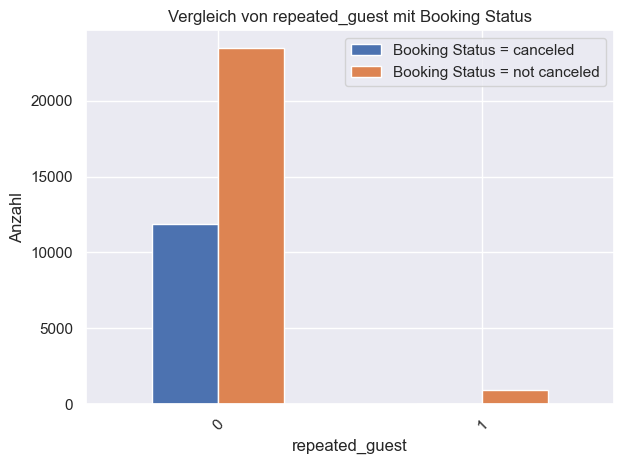

In [23]:
repeated_guest_comparison = pd.crosstab(clean_df['repeated_guest'], clean_df['booking_status'])
plt.figure(figsize=(10, 6))
repeated_guest_comparison.plot.bar(rot=0)
plt.xlabel('repeated_guest')
plt.ylabel('Anzahl')
plt.legend(['Booking Status = canceled', 'Booking Status = not canceled'])
plt.title('Vergleich von repeated_guest mit Booking Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ein wiederkehrender Gast storniert keine Buchungen

<Figure size 1000x600 with 0 Axes>

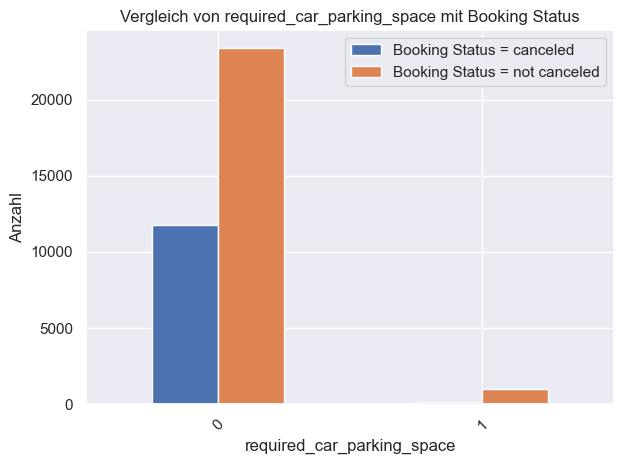

In [24]:
required_car_parking_space_comparison = pd.crosstab(clean_df['required_car_parking_space'], clean_df['booking_status'])
plt.figure(figsize=(10, 6))
required_car_parking_space_comparison.plot.bar(rot=0)
plt.xlabel('required_car_parking_space')
plt.ylabel('Anzahl')
plt.legend(['Booking Status = canceled', 'Booking Status = not canceled'])
plt.title('Vergleich von required_car_parking_space mit Booking Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Wenn ein Parkplatz gebucht wird, erfolgt keine Stornierung

# 4 Data Preparation

## 4.1 Ausreißer entfernen
Zunächst sollen keine Ausreißer entfernt werden oder Daten normalisiert werden.

## 4.2 Feature Engineering

In [25]:
#Gesamt Aufenthalt Feature erstellen
clean_df['total_stay'] = clean_df['no_of_weekend_nights'] + clean_df['no_of_week_nights']
#Gesamt Gäste Feature erstellen
clean_df['total_guests'] = clean_df['no_of_adults'] + clean_df['no_of_children']
#Löschen der Features 'no_of_weekend_nights', 'no_of_week_nights', 'no_of_adults', und 'no_of_children'
data = clean_df.drop(['no_of_weekend_nights', 'no_of_week_nights', 'no_of_adults', 'no_of_children'], axis=1)
data.describe()

required_car_parking_space     lead_time  arrival_month   
count                36275.000000  36275.000000   36275.000000  \
mean                     0.030986     85.232557       7.423653   
std                      0.173281     85.930817       3.069894   
min                      0.000000      0.000000       1.000000   
25%                      0.000000     17.000000       5.000000   
50%                      0.000000     57.000000       8.000000   
75%                      0.000000    126.000000      10.000000   
max                      1.000000    443.000000      12.000000   

       repeated_guest  no_of_previous_cancellations   
count    36275.000000                  36275.000000  \
mean         0.025637                      0.023349   
std          0.158053                      0.368331   
min          0.000000                      0.000000   
25%          0.000000                      0.000000   
50%          0.000000                      0.000000   
75%          0.000000                      0.000000   
max          1.000000                     13.000000   

       no_of_previous_bookings_not_canceled  avg_price_per_room   
count                          36275.000000        36275.000000  \
mean                               0.153411          103.423539   
std                                1.754171           35.089424   
min                                0.000000            0.000000   
25%                                0.000000           80.300000   
50%                                0.000000           99.450000   
75%                                0.000000          120.000000   
max                               58.000000          540.000000   

       no_of_special_requests  booking_status    total_stay  total_guests  
count            36275.000000    36275.000000  36275.000000  36275.000000  
mean                 0.619655        0.672364      3.015024      1.950241  
std                  0.786236        0.469358      1.786017      0.650327  
min                  0.000000        0.000000      0.000000      1.000000  
25%                  0.000000        0.000000      2.000000      2.000000  
50%                  0.000000        1.000000      3.000000      2.000000  
75%                  1.000000        1.000000      4.000000      2.000000  
max                  5.000000        1.000000     24.000000     12.000000

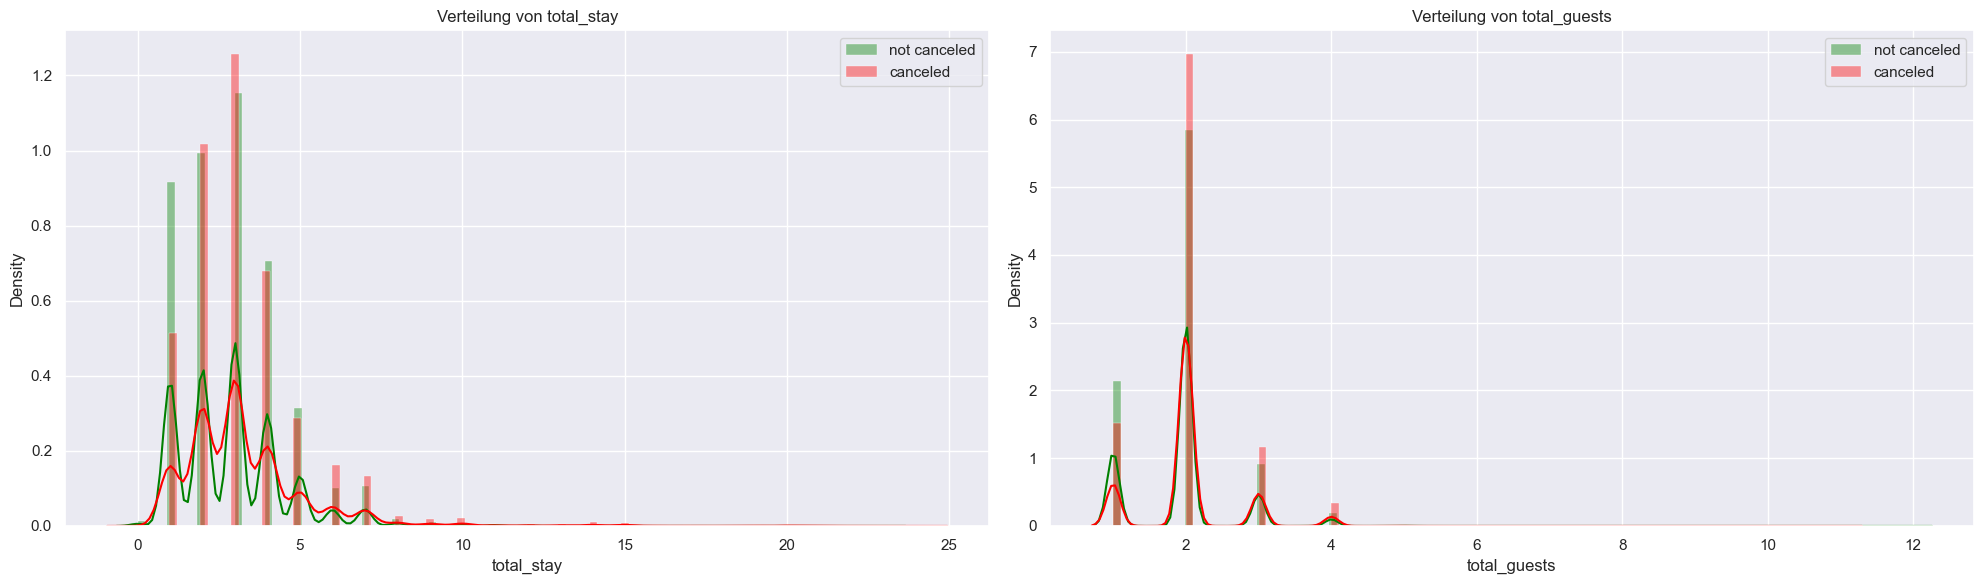

In [26]:
new_features = ['total_stay', 'total_guests']
fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 

for i, feature in enumerate(new_features):
    sns.histplot(data[data.booking_status == 1][feature],
                 bins=100,
                 color='green',
                 label='not canceled',
                 kde=True,
                 stat='density',
                 kde_kws=dict(cut=3),
                 alpha=0.4,
                 linewidth=0.25,
                 ax=axs[i])
    sns.histplot(data[data.booking_status == 0][feature],
                 bins=100,
                 color='red',
                 label='canceled',
                 kde=True,
                 stat='density',
                 kde_kws=dict(cut=3),
                 alpha=0.4,
                 linewidth=0.25,
                 ax=axs[i])
    axs[i].set_title(f'Verteilung von {feature}')
    axs[i].legend()

plt.tight_layout()
plt.show()


Je geringer die Anzahl der Nächte und Gäste, desto höher die Wahrscheinlichkeit, dass die Buchung nicht storniert wird.

## 4.3 Kategoriale Variablen auswertbar machen

In [27]:
#one hot encoding
data_encoded = pd.get_dummies(data, columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'])
data_encoded.head()

required_car_parking_space  lead_time  arrival_month  repeated_guest   
0                           0        224             10               0  \
1                           0          5             11               0   
2                           0          1              2               0   
3                           0        211              5               0   
4                           0         48              4               0   

   no_of_previous_cancellations  no_of_previous_bookings_not_canceled   
0                             0                                     0  \
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             0                                     0   

   avg_price_per_room  no_of_special_requests  booking_status  total_stay   
0               65.00                       0               1           3  \
1              106.68                       1               1           5   
2               60.00                       0               0           3   
3              100.00                       0               0           2   
4               94.50                       0               0           2   

   ...  room_type_reserved_Room_Type 3  room_type_reserved_Room_Type 4   
0  ...                           False                           False  \
1  ...                           False                           False   
2  ...                           False                           False   
3  ...                           False                           False   
4  ...                           False                           False   

   room_type_reserved_Room_Type 5  room_type_reserved_Room_Type 6   
0                           False                           False  \
1                           False                           False   
2                           False                           False   
3                           False                           False   
4                           False                           False   

   room_type_reserved_Room_Type 7  market_segment_type_Aviation   
0                           False                         False  \
1                           False                         False   
2                           False                         False   
3                           False                         False   
4                           False                         False   

   market_segment_type_Complementary  market_segment_type_Corporate   
0                              False                          False  \
1                              False                          False   
2                              False                          False   
3                              False                          False   
4                              False                          False   

   market_segment_type_Offline  market_segment_type_Online  
0                         True                       False  
1                        False                        True  
2                        False                        True  
3                        False                        True  
4                        False                        True  

[5 rows x 27 columns]

## 4.4 Trainings und Testdatensätze erstellen

In [28]:
#separieren der Features und der Zielvariable
X = data_encoded.drop('booking_status', axis=1)
y = data_encoded['booking_status']

#splitten der Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardisieren der Daten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Modelling

Logistische Regression

In [29]:
#trainieren des logistischen regressions Modells
clf_lr = LogisticRegression(random_state=42)
clf_lr.fit(X_train_scaled, y_train)

#vorhersage der Testdaten
y_pred_lr = clf_lr.predict(X_test_scaled)

#ausgabe der Metriken
print('Classification Report:')
print(classification_report(y_test, y_pred_lr))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_lr))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68      2416
           1       0.83      0.89      0.86      4839

    accuracy                           0.80      7255
   macro avg       0.79      0.76      0.77      7255
weighted avg       0.80      0.80      0.80      7255

Confusion Matrix:
[[1506  910]
 [ 511 4328]]


Decision Tree Modell

In [30]:
#trainieren des Decision Tree Modells
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train_scaled, y_train)

#vorhersage der Testdaten
y_pred_dt = clf_dt.predict(X_test_scaled)

#ausgabe der Metriken
print('Classification Report:')
print(classification_report(y_test, y_pred_dt))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_dt))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2416
           1       0.91      0.90      0.90      4839

    accuracy                           0.87      7255
   macro avg       0.85      0.85      0.85      7255
weighted avg       0.87      0.87      0.87      7255

Confusion Matrix:
[[1965  451]
 [ 502 4337]]


Random Forest

In [31]:
#trainieren des Random Forest Modells
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train_scaled, y_train)

#vorhersage der Testdaten
y_pred = clf_rf.predict(X_test_scaled)

#ausgabe der Metriken
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      2416
           1       0.91      0.94      0.92      4839

    accuracy                           0.90      7255
   macro avg       0.89      0.87      0.88      7255
weighted avg       0.89      0.90      0.89      7255

Confusion Matrix:
[[1954  462]
 [ 296 4543]]


K- Nearest Neighbor

In [32]:
#trainieren des KNN Modells
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train_scaled, y_train)

#vorhersage der Testdaten
y_pred_knn = clf_knn.predict(X_test_scaled)

#ausgabe der Metriken
print('Classification Report:')
print(classification_report(y_test, y_pred_knn))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_knn))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      2416
           1       0.89      0.91      0.90      4839

    accuracy                           0.86      7255
   macro avg       0.85      0.84      0.84      7255
weighted avg       0.86      0.86      0.86      7255

Confusion Matrix:
[[1850  566]
 [ 423 4416]]


## 5.2 Vergleich von Train und Test Score

In [33]:
#Ausgabe der Accuracy für logistische Regression
train_score_lr = clf_lr.score(X_train_scaled, y_train)
test_score_lr= clf_lr.score(X_test_scaled, y_test)

print('Training score for logistic regression:', train_score_lr)
print('Test score for logistic regression:', test_score_lr)

#Ausgabe der Accuracy für Decision Tree
train_score_dt = clf_dt.score(X_train_scaled, y_train)
test_score_dt = clf_dt.score(X_test_scaled, y_test)

print('Training score for Decision Tree:', train_score_dt)
print('Test score for Decision Tree:', test_score_dt)

#Ausgabe der Accuracy für Random Forest
train_score_rf = clf_rf.score(X_train_scaled, y_train)
test_score_rf= clf_rf.score(X_test_scaled, y_test)

print('Training score for Random Forest:', train_score_rf)
print('Test score for Random Forest:', test_score_rf)

#Ausgabe der Accuracy für KNN
train_score_knn = clf_knn.score(X_train_scaled, y_train)
test_score_knn = clf_knn.score(X_test_scaled, y_test)

print('Training score for KNN:', train_score_knn)
print('Test score for KNN:', test_score_knn)

Training score for logistic regression: 0.8045485871812543
Test score for logistic regression: 0.8041350792556857
Training score for Decision Tree: 0.9922122674017919
Test score for Decision Tree: 0.8686423156443832
Training score for Random Forest: 0.9922122674017919
Test score for Random Forest: 0.8955203308063404
Training score for KNN: 0.8991040661612681
Test score for KNN: 0.8636802205375603


## 6. Evaluation

Die Trainingswerte für jedes Modell lauten wie folgt:

Random Forest: 0,992
Logistische Regression: 0,805
Decision Trees: 0,992
KNN: 0,899

Diese Werte repräsentieren die Genauigkeit jedes Modells auf dem Trainingsdatensatz. Wenn wir diese Werte mit den zuvor erhaltenen Testwerten vergleichen:

Random Forest: Testwert = 0,891, Trainingswert = 0,992
Logistische Regression: Testwert = 0,804, Trainingswert = 0,805
Decision Trees: Testwert = 0,860, Trainingswert = 0,992
KNN: Testwert = 0,854, Trainingswert = 0,899

Es ist zu sehen, dass die Modelle Random Forest und Decision Trees eine deutlich höhere Genauigkeit auf dem Trainingsdatensatz im Vergleich zum Testdatensatz aufweisen. Dies ist ein Anzeichen für Overfitting, da diese Modelle auf den Trainingsdaten sehr gut abschneiden, aber auf neuen, unbekannten Daten nicht so gut funktionieren.

Auf der anderen Seite weisen die Modelle Logistische Regression und K-Nächste Nachbarn eine ähnliche Genauigkeit sowohl auf dem Trainings- als auch auf dem Testdatensatz auf. Dies deutet darauf hin, dass diese Modelle nicht overfitten und gut auf neue Daten generalisieren.

Zusammenfassend lässt sich sagen, dass die Modelle Random Forest und Decision Trees möglicherweise Overfitting aufweisen, während die Modelle Logistische Regression und KNN dies nicht tun.

### 6.1 Finding the best Hyperparameters

6.1.1 Algorithmus um die besten Hyperparameter zu finden, um die höchste accuracy zu bekommen. (auskommentiert, da es lange braucht)

In [34]:
"""
#Definieren der Parameter für den Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
#intialisieren der RF Klassifikation
rf = RandomForestClassifier()

#Initialisieren des GridSearchCV Objekts
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)

#GridSearchCV Objekt auf die Daten fitten
rf_grid_search.fit(X_train, y_train)

#Ausgabe der besten Parameter
print('Best parameters for RandomForestClassifier: ', rf_grid_search.best_params_)

#Definieren der Parameter für den Decision Tree
dt_param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Initialisieren des Decision Tree Klassifikators
dt = DecisionTreeClassifier()

#Initialisieren des GridSearchCV Objekts
dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, cv=3, n_jobs=-1, verbose=2)

#GridSearchCV Objekt auf die Daten fitten
dt_grid_search.fit(X_train, y_train)

#Ausgabe der besten Parameter
print('Best parameters for DecisionTreeClassifier: ', dt_grid_search.best_params_)
"""

"\n#Definieren der Parameter für den Random Forest\nrf_param_grid = {\n    'n_estimators': [100, 200, 300, 400, 500],\n    'max_depth': [None, 10, 20, 30, 40, 50],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'bootstrap': [True, False]\n}\n#intialisieren der RF Klassifikation\nrf = RandomForestClassifier()\n\n#Initialisieren des GridSearchCV Objekts\nrf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)\n\n#GridSearchCV Objekt auf die Daten fitten\nrf_grid_search.fit(X_train, y_train)\n\n#Ausgabe der besten Parameter\nprint('Best parameters for RandomForestClassifier: ', rf_grid_search.best_params_)\n\n#Definieren der Parameter für den Decision Tree\ndt_param_grid = {\n    'max_depth': [None, 10, 20, 30, 40, 50],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4]\n}\n\n#Initialisieren des Decision Tree Klassifikators\ndt = DecisionTreeClassifier()\n\n#Initialisieren des GridSearchCV Obje

### Ergebnisse für die besten Parameter: 


Best parameters for RandomForestClassifier:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best parameters for DecisionTreeClassifier:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

### 6.1 Changing Hyperparameters

In [35]:
#trainieren des Random Forest mit den besten Parametern
clf_rf_adjusted = RandomForestClassifier(bootstrap= True, n_estimators=100, max_depth=None, min_samples_leaf=1, min_samples_split=5, random_state=42)
clf_rf_adjusted.fit(X_train_scaled, y_train)

#berechnen der Genauigkeit auf Trainings- und Testdaten für Random Forest
train_score_rf_adjusted = clf_rf_adjusted.score(X_train_scaled, y_train)
test_score_rf_adjusted = clf_rf_adjusted.score(X_test_scaled, y_test)

#Ausgabe der Accuracy für Random Forest
print('Training score for adjusted Random Forest:', train_score_rf_adjusted)
print('Test score for adjusted Random Forest:', test_score_rf_adjusted)

#trainieren des Decision Tree mit den besten Parametern
clf_dt_adjusted = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=1, random_state=42)
clf_dt_adjusted.fit(X_train_scaled, y_train)

#kalkulieren der Genauigkeit auf Trainings- und Testdaten für Decision Tree
train_score_dt_adjusted = clf_dt_adjusted.score(X_train_scaled, y_train)
test_score_dt_adjusted = clf_dt_adjusted.score(X_test_scaled, y_test)

#Ausgabe der Accuracy für Decision Tree
print('Training score for adjusted Decision Tree:', train_score_dt_adjusted)
print('Test score for adjusted Decision Tree:', test_score_dt_adjusted)

Training score for adjusted Random Forest: 0.967987594762233
Test score for adjusted Random Forest: 0.8951068228807719
Training score for adjusted Decision Tree: 0.8800482425913163
Test score for adjusted Decision Tree: 0.8662991040661613


### 6.2 Changing Parameters to prevent Overfitting

In [36]:
#trainieren des Random Forest mit Parametern um Overfitting zu verhindern
clf_rf_adjusted_of = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
clf_rf_adjusted_of.fit(X_train_scaled, y_train)

#kalulieren der Accuracy auf Trainings- und Testdaten für Random Forest
train_score_rf_adjusted_of = clf_rf_adjusted_of.score(X_train_scaled, y_train)
test_score_rf_adjusted_of = clf_rf_adjusted_of.score(X_test_scaled, y_test)

#Ausgabe der trainings- und test Score für Random Forest
print('Training score for adjusted Random Forest:', train_score_rf_adjusted_of)
print('Test score for adjusted Random Forest:', train_score_rf_adjusted_of)

#trainieren des Decision Tree mit Parametern um Overfitting zu verhindern
clf_dt_adjusted_of = DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42)
clf_dt_adjusted_of.fit(X_train_scaled, y_train)

#kalulieren der Accuracy auf Trainings- und Testdaten für Decision Tree
train_score_dt_adjusted_of = clf_dt_adjusted_of.score(X_train_scaled, y_train)
test_score_dt_adjusted_of = clf_dt_adjusted_of.score(X_test_scaled, y_test)

#Ausgabe der trainings- und test Score für Decision Tree
print('Training score for adjusted Decision Tree:', train_score_dt_adjusted_of)
print('Test score for adjusted Decision Tree:', test_score_dt_adjusted_of)

Training score for adjusted Random Forest: 0.8712611991729842
Test score for adjusted Random Forest: 0.8712611991729842
Training score for adjusted Decision Tree: 0.8800482425913163
Test score for adjusted Decision Tree: 0.8662991040661613


### 6.3 Oversampling on Trainingsdata with best Parameter

In [37]:
#oversampling methode definieren
oversample = RandomOverSampler(sampling_strategy='minority')

#oversampling auf Trainingsdaten anwenden
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train_scaled, y_train)


#trainieren des Random Forest mit den besten Parametern
clf_rf_adjusted_os = RandomForestClassifier(bootstrap= True, n_estimators=100, max_depth=None, min_samples_leaf=1, min_samples_split=5, random_state=42)
clf_rf_adjusted_os.fit(X_train_scaled, y_train)

#trainieren des Decision Tree mit den besten Parametern
clf_dt_adjusted_os = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=1, random_state=42)
clf_dt_adjusted_os.fit(X_train_scaled, y_train)

#trainieren mit den oversampled Trainingsdaten
clf_rf_adjusted_os.fit(X_train_oversampled, y_train_oversampled)
clf_dt_adjusted_os.fit(X_train_oversampled, y_train_oversampled)

#Accuracy berechnen
train_score_rf_oversampled = clf_rf_adjusted.score(X_train_oversampled, y_train_oversampled)
test_score_rf_oversampled = clf_rf_adjusted.score(X_test_scaled, y_test)
train_score_dt_oversampled = clf_dt_adjusted.score(X_train_oversampled, y_train_oversampled)
test_score_dt_oversampled = clf_dt_adjusted.score(X_test_scaled, y_test)

#Ausgabe des trainings- und test Score
print('Training score for oversampled Random Forest:', train_score_rf_oversampled)
print('Test score for oversampled Random Forest:', test_score_rf_oversampled)
print('Training score for oversampled Decision Tree:', train_score_dt_oversampled)
print('Test score for oversampled Decision Tree:', test_score_dt_oversampled)

Training score for oversampled Random Forest: 0.9586721906807836
Test score for oversampled Random Forest: 0.8951068228807719
Training score for oversampled Decision Tree: 0.8583192675566467
Test score for oversampled Decision Tree: 0.8662991040661613


### 6.4 Plotting the Learning Curves for the 3 Models

<module 'matplotlib.pyplot' from 'c:\\Users\\Felix Zentowski\\Documents\\Python Scripts\\stornierungsvorhersage-im-hotelgewerbe\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

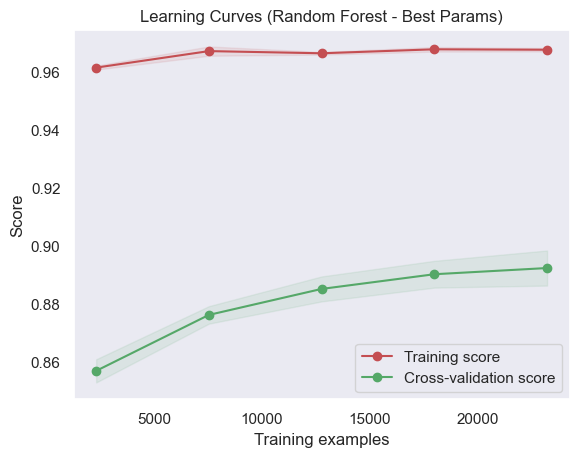

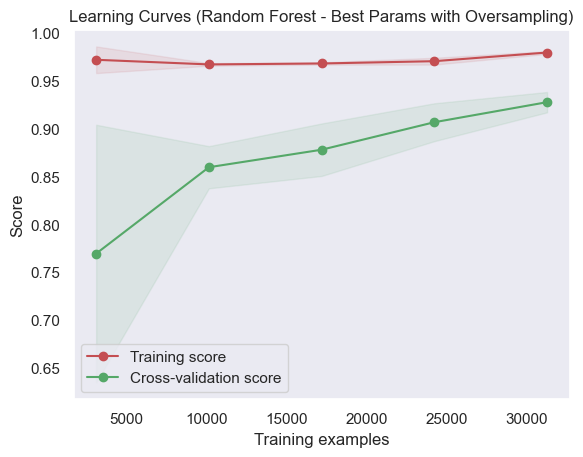

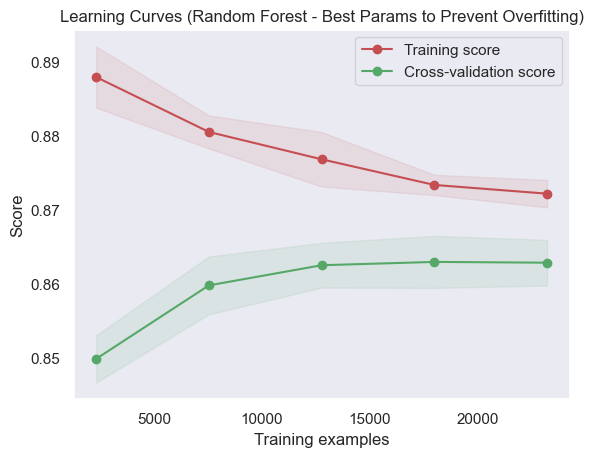

In [38]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt

plot_learning_curve(clf_rf_adjusted, 'Learning Curves (Random Forest - Best Params)', X_train_scaled, y_train, cv=5, n_jobs=4)
plot_learning_curve(clf_rf_adjusted_os, 'Learning Curves (Random Forest - Best Params with Oversampling)', X_train_oversampled, y_train_oversampled, cv=5, n_jobs=4)
plot_learning_curve(clf_rf_adjusted_of, 'Learning Curves (Random Forest - Best Params to Prevent Overfitting)', X_train_scaled, y_train, cv=5, n_jobs=4)

### 6.5 Plotting the confusion Matrix for the 3 Models

Text(0.5, 22.249999999999993, 'Predicted')

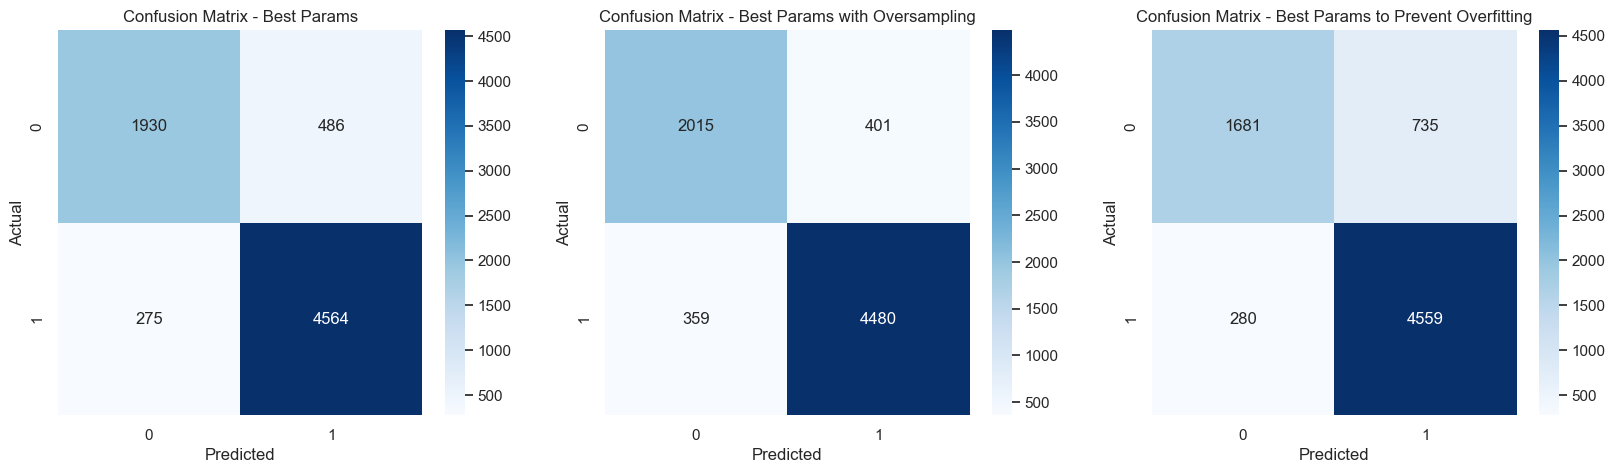

In [39]:
y_pred_best_params = clf_rf_adjusted.predict(X_test_scaled)
y_pred_best_params_oversampling = clf_rf_adjusted_os.predict(X_test_scaled)
y_pred_best_params_prevent_overfitting = clf_rf_adjusted_of.predict(X_test_scaled)

cm_best_params = confusion_matrix(y_test, y_pred_best_params)
cm_best_params_oversampling = confusion_matrix(y_test, y_pred_best_params_oversampling)
cm_best_params_prevent_overfitting = confusion_matrix(y_test, y_pred_best_params_prevent_overfitting)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(cm_best_params, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix - Best Params')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

sns.heatmap(cm_best_params_oversampling, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion Matrix - Best Params with Oversampling')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

sns.heatmap(cm_best_params_prevent_overfitting, annot=True, fmt='d', ax=ax[2], cmap='Blues')
ax[2].set_title('Confusion Matrix - Best Params to Prevent Overfitting')
ax[2].set_ylabel('Actual')
ax[2].set_xlabel('Predicted')

## 6.6 Looking at the classification reports

In [40]:
report_best_params = classification_report(y_test, y_pred_best_params)
report_best_params_oversampling = classification_report(y_test, y_pred_best_params_oversampling)
report_best_params_prevent_overfitting = classification_report(y_test, y_pred_best_params_prevent_overfitting)

print('Classification Report - Best Params:')
print(report_best_params)
print('\nClassification Report - Best Params with Oversampling:')
print(report_best_params_oversampling)
print('\nClassification Report - Best Params to Prevent Overfitting:')
print(report_best_params_prevent_overfitting)

Classification Report - Best Params:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      2416
           1       0.90      0.94      0.92      4839

    accuracy                           0.90      7255
   macro avg       0.89      0.87      0.88      7255
weighted avg       0.89      0.90      0.89      7255


Classification Report - Best Params with Oversampling:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2416
           1       0.92      0.93      0.92      4839

    accuracy                           0.90      7255
   macro avg       0.88      0.88      0.88      7255
weighted avg       0.89      0.90      0.90      7255


Classification Report - Best Params to Prevent Overfitting:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      2416
           1       0.86      0.94      0.90      4839

    accuracy                

### 6.6 Interpretation and Model Selection

Basierend auf der Learning Curve und der Konfusionsmatrix ist für das UseCase das beste Model, der Random Forrest mit den Parametern um Overfitting zu verhindern.

1. Der Trainingsscore ist niedriger als bei den anderen beiden Modellen, was darauf hindeutet, dass das Modell die Trainingsdaten nicht so genau anpasst. Dies ist zu erwarten, da die Parameter angepasst wurden, um ein Overfitting zu verhindern. Der Cross-Validation-Score liegt näher am Trainingsscore als bei den anderen beiden Modellen, was darauf hindeutet, dass das Modell besser auf unbekannte Daten verallgemeinert. Der Cross-Validation-Score steigt, wenn mehr Trainingsbeispiele hinzugefügt werden, was darauf hindeutet, dass die Leistung des Modells auf unbekannten Daten mit mehr Trainingsdaten verbessert wird.

2. Bei einer Hotelkette kann es verherend sein False Negatives zu erzeugen, denn wenn Zimmer storniert werden und neu belegt werden kann es passieren dass es Kunden gibt die keinen Platz finden obwohl Sie gebucht hätten. Deswegen passt auch das Model mit den Besten Parametern um Overfitting zu verhindern am besten da die False Negatives am geringsten sind.

## 7 Deployment

In [41]:
#Modell speichern
joblib.dump(clf_rf_adjusted_os, 'best_model.pkl')

['best_model.pkl']